In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

### Часть 0. Подготовка

Скачайте обучающую выборку из [этого](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview) соревнования и загрузите ее:

In [2]:
samp_sub_path = 'nyc-taxi-trip-duration/sample_submission.csv'
test_path = 'nyc-taxi-trip-duration/test.csv'
train_path = 'nyc-taxi-trip-duration/train.csv'

df = pd.read_csv(train_path, parse_dates=['pickup_datetime'])

In [3]:
df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


#### Data fields
id - a unique identifier for each trip\
vendor_id - a code indicating the provider associated with the trip record\
pickup_datetime - date and time when the meter was engaged\
dropoff_datetime - date and time when the meter was disengaged\
passenger_count - the number of passengers in the vehicle (driver entered value)\
pickup_longitude - the longitude where the meter was engaged\
pickup_latitude - the latitude where the meter was engaged\
dropoff_longitude - the longitude where the meter was disengaged\
dropoff_latitude - the latitude where the meter was disengaged\
store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip\
**trip_duration** - duration of the trip in seconds

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [4]:
# этой колонки нет в тестовой выборке
df.drop(columns='dropoff_datetime', inplace=True)

Изучаем признак 'trip_duration'

In [6]:
# раскомментировать перед загрузкой
sns.displot(df['trip_duration'], bins=5, kde=True)

Логарифмируем признак 'trip_duration'

In [5]:
# раскомментировать перед загрузкой
df['log_trip_duration'] = np.log1p(df['trip_duration'])
sns.displot(df['log_trip_duration'], bins=11, kde=True)

Удаляем первоначальный таргет:

In [8]:
df.drop(columns='trip_duration', inplace=True)

Проверяем значение RMSLE при константном предсказании:

In [9]:
from sklearn.metrics import mean_squared_error

In [10]:
df['const'] = df['log_trip_duration'].mean()

rmsle = mean_squared_error(df['const'], df['log_trip_duration'], squared=False)

df.drop(columns='const', inplace=True)

rmsle

0.7957592365411509

Text(0.5, 0.98, 'Количество поездок за день')

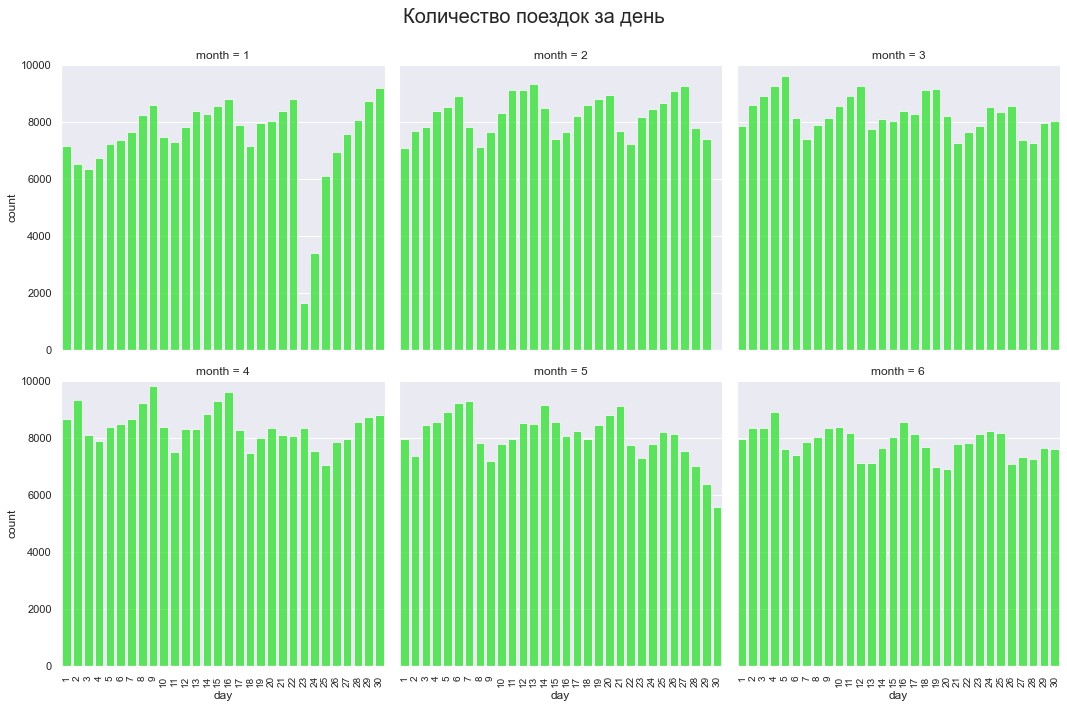

In [11]:

df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day

g = sns.FacetGrid(df, col='month', col_wrap=3, height=5, ylim=(0,10000))
g.map(sns.countplot, 'day', color='lime', alpha=0.7,
      order=[i for i in range(1,31)])
g.set_xticklabels(fontsize=10, rotation=90)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Количество поездок за день', fontsize=20)

#df.drop(columns=['month','day'], inplace=True)

На графиках видны несколько дней, в которых количество поездок было значительно ниже, чем обычно: 
* 23-24 января 2016 (в эти дни в Нью-Йорке была аномальная метель)
* 30 мая (день поминовения в США)

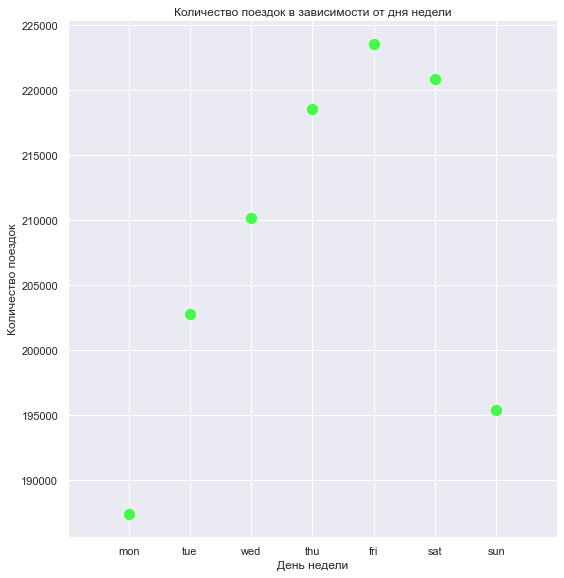

In [12]:
df['day_of_week'] = df['pickup_datetime'].dt.day_of_week
ax = sns.relplot(x=df['day_of_week'].value_counts().index,
                 y=df['day_of_week'].value_counts().values,
                 s=150, color='lime', alpha=0.7, height=8)
ax.set(title='Количество поездок в зависимости от дня недели',
       xlabel='День недели',
       ylabel='Количество поездок')
ax.set_xticklabels(['','mon','tue','wed','thu','fri','sat','sun',''])

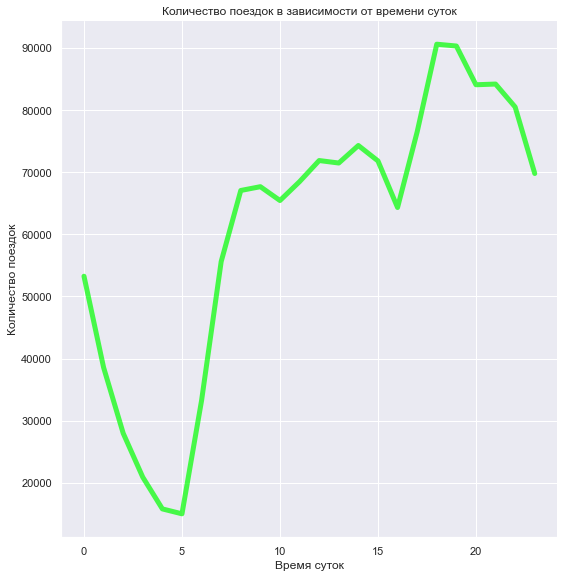

In [13]:
df['hour'] = df['pickup_datetime'].dt.hour
ax = sns.relplot(x=df['hour'].value_counts().index,
                 y=df['hour'].value_counts().values,
                 color='lime', alpha=0.7, kind='line',
                 height=8, linewidth=5)#s=150, 
ax.set(title='Количество поездок в зависимости от времени суток',
       xlabel='Время суток',
       ylabel='Количество поездок')

In [14]:
gb_month_hour = pd.DataFrame(df.groupby(by=['month','hour'])['id'].count())

gb_month_hour.reset_index(level=['month','hour'], inplace=True)

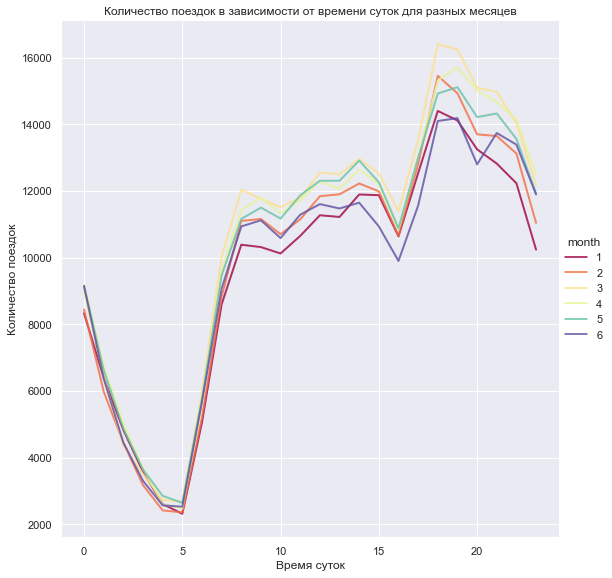

In [15]:
ax = sns.relplot(data=gb_month_hour, x='hour', y='id',
                 alpha=0.8, kind='line', palette='Spectral',
                 height=8, linewidth=2, hue='month')
ax.set(title='Количество поездок в зависимости от времени суток для разных месяцев',
       xlabel='Время суток',
       ylabel='Количество поездок')

В разные месяцы зависимость количества поездок от времени суток значительно не менялась

In [16]:
gb_dow_hour = pd.DataFrame(df.groupby(by=['day_of_week','hour'])['id'].count())

gb_dow_hour.reset_index(level=['day_of_week','hour'], inplace=True)

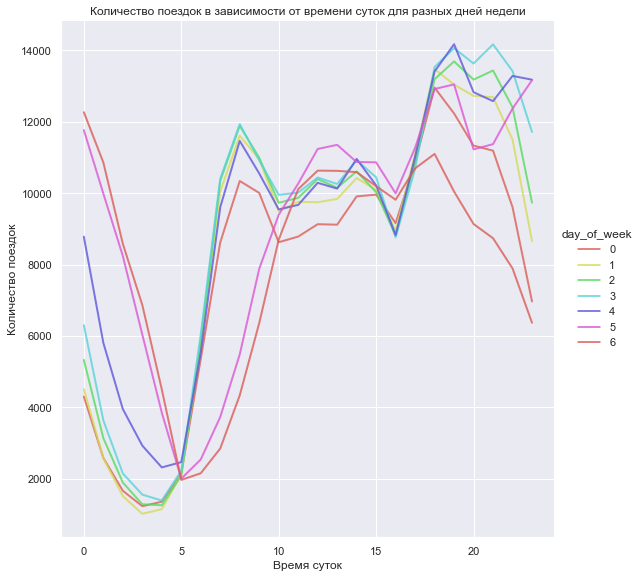

In [17]:
ax = sns.relplot(data=gb_dow_hour, x='hour', y='id',
                 alpha=0.8, kind='line', palette='hls',
                 height=8, linewidth=2, hue='day_of_week')
ax.set(title='Количество поездок в зависимости от времени суток для разных дней недели',
       xlabel='Время суток',
       ylabel='Количество поездок')

В субботу и воскресенье зависимость количества поездок от времени суток отличается от зависимости в будние дни:
* В период с 00 до 05 часов в выходные дни поездок больше, чем в будние дни (вероятнее всего, многие в это время возвращаются из баров, ресторанов, от друзей и т.д.)
* В период с 20 до 23 в пятницу и субботу также заметно увеличение количества поездок (можно объяснить теми же самыми причинами)
* В будние дни есть два периода с высокой активностью: 7 - 9 и 18 - 21, которых нет в выходные (люди едут на работу и возвращаюся с нее в это время)

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021050 entries, 430252 to 305711
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1021050 non-null  object        
 1   vendor_id           1021050 non-null  int64         
 2   pickup_datetime     1021050 non-null  datetime64[ns]
 3   passenger_count     1021050 non-null  int64         
 4   pickup_longitude    1021050 non-null  float64       
 5   pickup_latitude     1021050 non-null  float64       
 6   dropoff_longitude   1021050 non-null  float64       
 7   dropoff_latitude    1021050 non-null  float64       
 8   store_and_fwd_flag  1021050 non-null  object        
 9   log_trip_duration   1021050 non-null  float64       
 10  month               1021050 non-null  int64         
 11  day                 1021050 non-null  int64         
 12  day_of_week         1021050 non-null  int64         
 13  hour    

In [21]:
gb_dow_target = pd.DataFrame(df_train.groupby(by=['day_of_week'])['log_trip_duration'].mean())
gb_dow_target.reset_index(level=['day_of_week'], inplace=True)

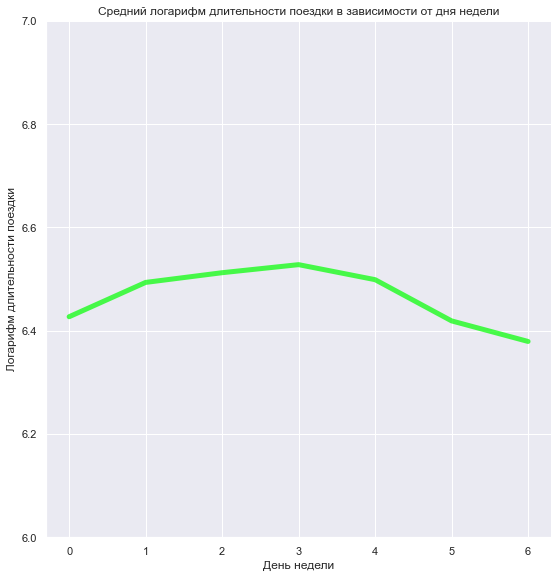

In [22]:
ax = sns.relplot(data=gb_dow_target, x='day_of_week',
                 y='log_trip_duration',
                 color='lime', alpha=0.7, kind='line',
                 height=8, linewidth=5)#s=150, 

ax.set(title='Средний логарифм длительности поездки в зависимости от дня недели',
       xlabel='День недели',
       ylabel='Логарифм длительности поездки', ylim=(6,7))

In [23]:
gb_hour_target = pd.DataFrame(df_train.groupby(by=['hour'])['log_trip_duration'].mean())
gb_hour_target.reset_index(level=['hour'], inplace=True)

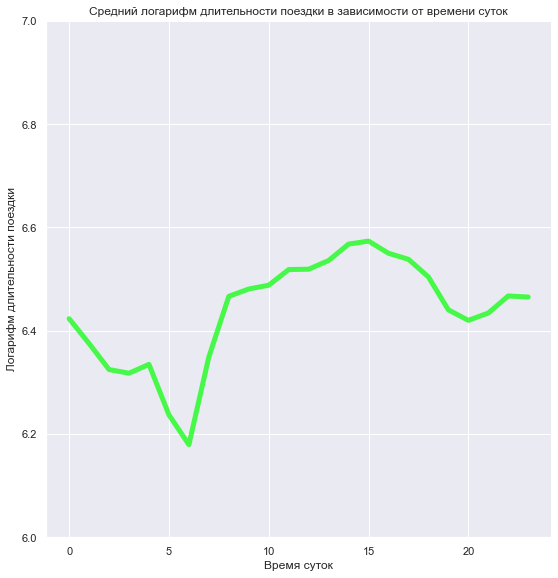

In [24]:
ax = sns.relplot(data=gb_hour_target, x='hour',
                 y='log_trip_duration',
                 color='lime', alpha=0.7, kind='line',
                 height=8, linewidth=5)#s=150, 

ax.set(title='Средний логарифм длительности поездки в зависимости от времени суток',
       xlabel='Время суток',
       ylabel='Логарифм длительности поездки', ylim=(6, 7))

In [25]:
gb_md = pd.DataFrame(df_train.groupby(by=['month','day'])['log_trip_duration'].mean())

gb_md.reset_index(level=['month','day'], inplace=True)

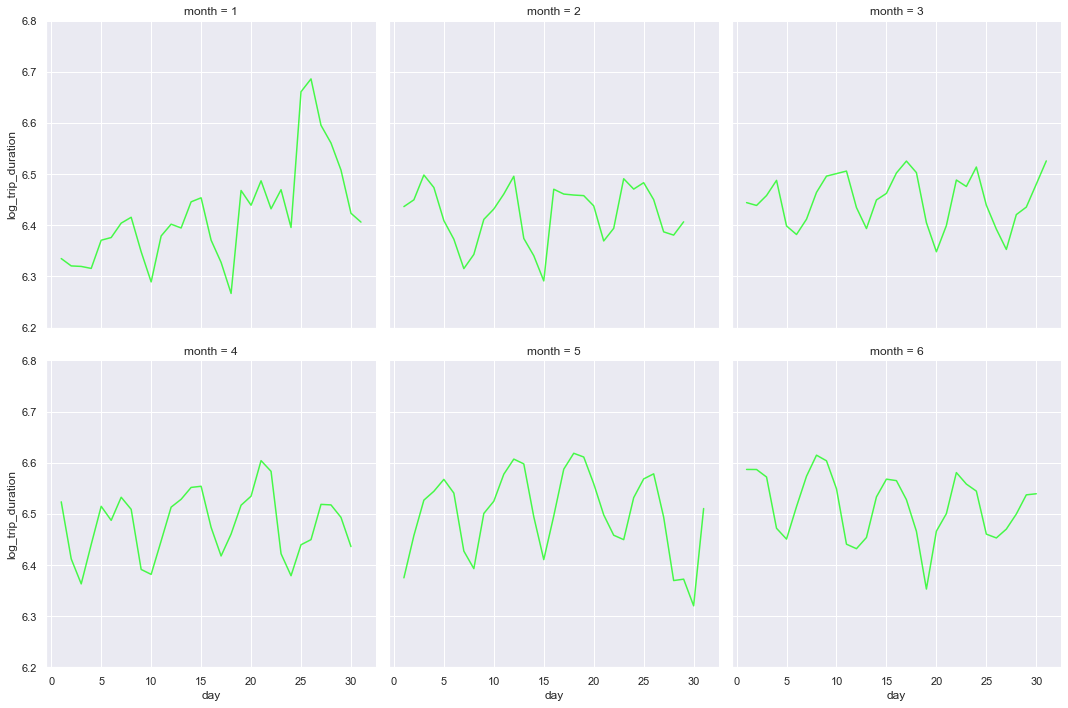

In [26]:
g = sns.FacetGrid(gb_md, col='month', col_wrap=3, height=5, ylim=(6.2,6.8))
g.map(sns.lineplot, 'day','log_trip_duration', color='lime', alpha=0.7)

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [27]:
def new_columns(df):
    #df = df.assign(is_anomaly_1=lambda x: 1 if x.day in [23,24,25] else 0)# and (x.month == 1) 
    df = df.assign(is_anomaly_1= ((df['day'] == 23) & (df['month'] == 1)) |\
        ((df['day'] == 24) & (df['month'] == 1)) |\
        ((df['day'] == 25) & (df['month'] == 1)))
    
    df = df.assign(is_anomaly_2= ((df['day'] == 30) & (df['month'] == 5)))
    df = df.assign(day_of_year= df['pickup_datetime'].dt.day_of_year)
    return df

In [28]:
df_train = new_columns(df_train)

In [29]:
df_train.drop(columns=['id','vendor_id','pickup_datetime','day'], inplace=True)

In [30]:
df_test = new_columns(df_test)
df_test.drop(columns=['id','vendor_id','pickup_datetime','day'], inplace=True)

In [31]:
X_train = df_train.drop(columns='log_trip_duration')
y_train = df_train['log_trip_duration']

In [32]:
X_test = df_test.drop(columns='log_trip_duration')
y_test = df_test['log_trip_duration']

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [34]:
categorical = ['store_and_fwd_flag','day_of_week','month','hour']
numeric_features = list(set.difference(set(X_train.columns),set(categorical)))

In [35]:
from sklearn.linear_model import Ridge

In [36]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))


Test RMSE = 0.7677


(rmsle для константного предсказания 0.796)

In [37]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [38]:
# раскомментировать перед загрузкой

# alphas = np.logspace(-3, 4, 20)
# searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}],
#                         scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
# searcher.fit(X_train, y_train)

# best_alpha = searcher.best_params_["regression__alpha"]
# print("Best alpha = %.4f" % best_alpha)

# plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
# plt.xscale("log")
# plt.xlabel("alpha")
# plt.ylabel("CV score")

### Часть 2

In [39]:
import folium

In [40]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [41]:
show_circles_on_map(df.sample(1000, random_state=0), "pickup_latitude", "pickup_longitude", "blue")

In [42]:
show_circles_on_map(df.sample(1000, random_state=0), "dropoff_latitude", "dropoff_longitude", "blue")

In [43]:
from haversine import haversine

In [44]:
df['haversine'] = df.apply(lambda x: haversine((x.pickup_latitude, x.pickup_longitude),
                                               (x.dropoff_latitude,x.dropoff_longitude)),
                           axis=1)


In [45]:
df[['haversine','log_trip_duration']].corr()

,haversine,log_trip_duration
haversine,1.000000,0.573595
log_trip_duration,0.573595,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='haversine', ylabel='log_trip_duration'>

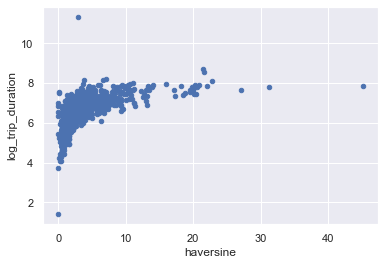

In [46]:
df[:1000].plot.scatter('haversine','log_trip_duration')

In [47]:
df['log_haversine'] = np.log1p(df['haversine'])

In [48]:
df[['haversine', 'log_haversine', 'log_trip_duration']].corr()

,haversine,log_haversine,log_trip_duration
haversine,1.000000,0.844501,0.573595
log_haversine,0.844501,1.000000,0.749882
log_trip_duration,0.573595,0.749882,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='log_haversine', ylabel='log_trip_duration'>

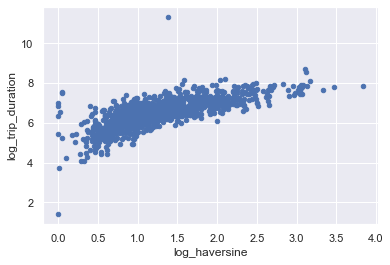

In [49]:
df[:1000].plot.scatter('log_haversine','log_trip_duration')

In [50]:
df['av_speed_loglog'] = df['log_haversine'] / df['log_trip_duration']

<AxesSubplot:ylabel='Frequency'>

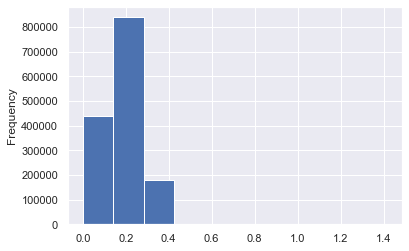

In [51]:
df['av_speed_loglog'].plot.hist(bins=10)

<AxesSubplot:ylabel='Frequency'>

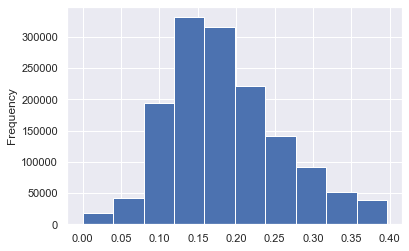

In [52]:
df[df['av_speed_loglog'] < df['av_speed_loglog'].quantile(q=0.99)]['av_speed_loglog'].plot.hist(bins=10)

In [53]:
gb_dow_hour_median = pd.DataFrame(df.groupby(by=['day_of_week','hour'])['av_speed_loglog'].median())
gb_dow_hour_median = gb_dow_hour_median.unstack()

Text(84.5, 0.5, 'День недели')

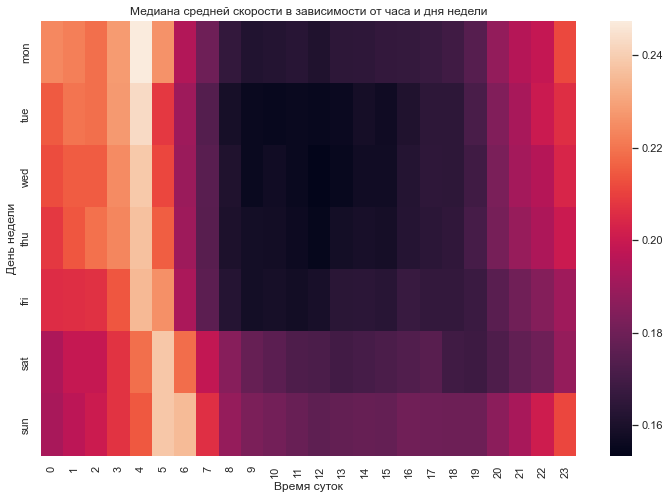

In [54]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(gb_dow_hour_median)
ax.set_yticklabels(['mon','tue','wed','thu','fri','sat','sun'])
ax.set_xticklabels([i for i in range(24)]); # ';' удаляет лишний текст перед графиком
ax.set_title('Медиана средней скорости в зависимости от часа и дня недели')
ax.set_xlabel('Время суток')
ax.set_ylabel('День недели')

In [55]:
gb_with_traffic = pd.DataFrame(df.groupby(by=['day_of_week','hour'])['av_speed_loglog'].median())
gb_with_traffic['av_speed_loglog'] = gb_with_traffic['av_speed_loglog'] < gb_with_traffic['av_speed_loglog'].quantile(0.3)
gb_with_traffic_u = gb_with_traffic.unstack()
gb_with_traffic.reset_index(level=['day_of_week','hour'], inplace=True)

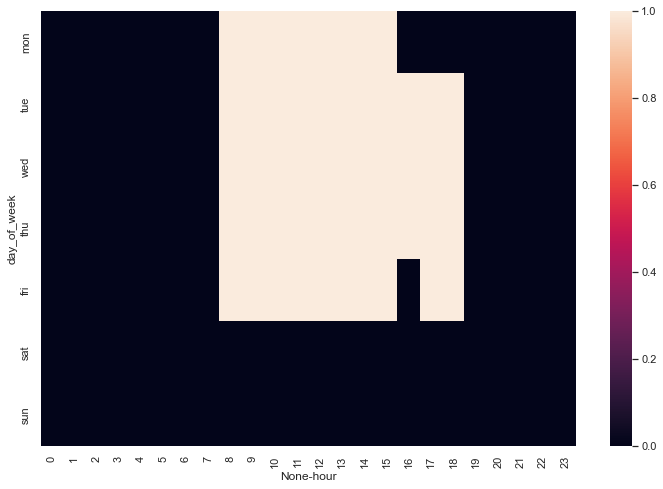

In [56]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(gb_with_traffic_u)
ax.set_yticklabels(['mon','tue','wed','thu','fri','sat','sun'])
ax.set_xticklabels([i for i in range(24)]);

In [57]:
traffic_d_h = gb_with_traffic[
    gb_with_traffic['av_speed_loglog']].apply(
             lambda x: (x.day_of_week, x.hour), axis=1).values

In [58]:
gb_no_traffic = pd.DataFrame(df.groupby(by=['day_of_week','hour'])['av_speed_loglog'].median())
gb_no_traffic['av_speed_loglog'] = gb_no_traffic['av_speed_loglog'] > gb_no_traffic['av_speed_loglog'].quantile(0.7)
gb_no_traffic_u = gb_no_traffic.unstack()
gb_no_traffic.reset_index(level=['day_of_week','hour'], inplace=True)

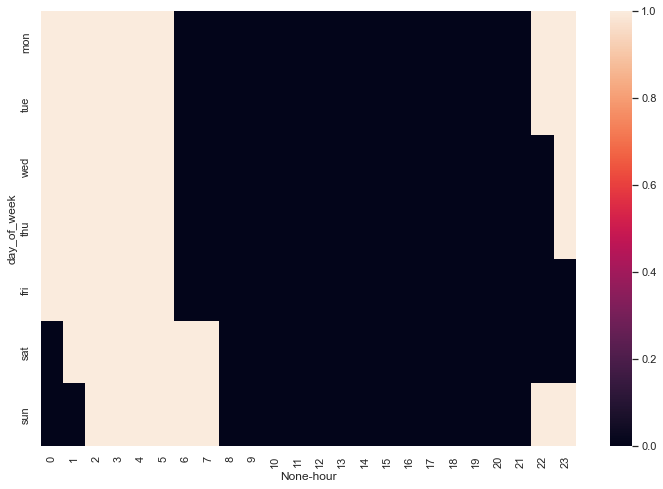

In [59]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(gb_no_traffic_u)
ax.set_yticklabels(['mon','tue','wed','thu','fri','sat','sun'])
ax.set_xticklabels([i for i in range(24)]);

In [60]:
no_traffic_d_h = gb_no_traffic[
    gb_no_traffic['av_speed_loglog']].apply(
             lambda x: (x.day_of_week, x.hour), axis=1).values

In [61]:
df = df.assign(trafic=df['day_of_week'].isin({x[0] for x in traffic_d_h}) & \
    df['hour'].isin({x[1] for x in traffic_d_h}),
    no_trafic=df['day_of_week'].isin({x[0] for x in no_traffic_d_h}) & \
    df['hour'].isin({x[1] for x in no_traffic_d_h}))

In [62]:
df.drop(columns=['haversine','av_speed_loglog'], inplace=True)

In [ ]:
from transformers import *

In [65]:
mgt = MapGridTransformer(5, 5)
df1 = mgt.fit_transform(df)

In [67]:
df1.drop(columns=['id','vendor_id','pickup_datetime','day'], inplace=True)

In [122]:
# X_train, X_test, y_train, y_test = train_test_split(
#     df1.drop(columns='log_trip_duration'),df1['log_trip_duration'], test_size=0.3, random_state=0)

In [123]:
# #
# categorical = ['store_and_fwd_flag','day_of_week','month','hour','pickup_square','dropoff_square']
# numeric_features = list(set.difference(set(X_train.columns),set(categorical)))

In [124]:
# column_transformer = ColumnTransformer([
#     ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
#     ('scaling', StandardScaler(), numeric_features)
# ])

# pipeline = Pipeline(steps=[
#     ('ohe_and_scaling', column_transformer),
#     ('regression', Ridge())
# ])

# model = pipeline.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4881


In [71]:
# import xgboost as xgb

In [125]:
# column_transformer = ColumnTransformer([
#     ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
#     ('scaling', StandardScaler(), numeric_features)
# ])

# pipeline = Pipeline(steps=[
#     ('ohe_and_scaling', column_transformer),
#     ('regression', xgb.XGBRegressor(max_depth=4))
# ])

# model = pipeline.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4255
